# Import libraries

In [44]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab
import itertools
import os
os.chdir('/content/drive/My Drive/Carbon_price_prediction/Workspace/Data')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

In [45]:
old_keywords = False
keyword_generation = 'old' if old_keywords else 'new'

methodology = 'tf_idf' # 'tf_idf' or 'bag_of_words'
data_source = 'gdelt' # 'gdelt'
glossary_source = 'lemmatized_grouped_custom' # 'BBC' or 'IPCC' or 'custom' or 'lemmatized_custom'
version = '' # 'new' or '' for old (in case of BBC), otherwise use ''
loss_measure = 'MAPE (scaled)' #'RMSE' or 'MAPE' or 'MAE' or 'MAPE (scaled)' or 'R2'
loss_measure_control_normalization = False
interaction_terms = False
volatility_prediction = True

rolling_mean_length = 30
rolling_corr_length = 60
dep_var = 'carbon_price'

# Constants

In [46]:
# TO-DO to update exact names!
var_name_map = {'carbon_price': 'EU ETS carbon price',
                'oil_price': 'Brent Oil Futures',
                'energy_price': 'Electricity Yearly Futures',
                'gas_price': 'Natural Gas Futures',
                'coal_price': 'Rotterdam Coal Futures',
                'stock_price': 'STOXX Europe 600 Index',
                'emissions': 'Emissions (group)',
                'fossil_fuel': 'Fossil fuels (group)',
                'gas': 'Gas (group)',
                'policy': 'Policy (group)',
                'renewables': 'Renewables (group)'}


methodology_name_map = {'tf_idf': 'TF-IDF'}

# Data import

In [47]:
predictors = pd.read_csv( "./new_data/new_merged_dataset.csv", index_col=0,
                         parse_dates=True, dayfirst=True)
predictors.index.name = 'date'
predictors.head()

,carbon_price,oil_price,energy_price,gas_price,coal_price,stock_price,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,6.12,56.82,NaN,NaN,NaN,363.18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,5.43,55.47,NaN,49.45,82.50,365.71,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,5.72,56.46,NaN,50.68,84.20,365.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,5.29,56.89,NaN,50.69,85.75,365.64,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,5.50,57.10,NaN,49.77,84.75,365.45,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


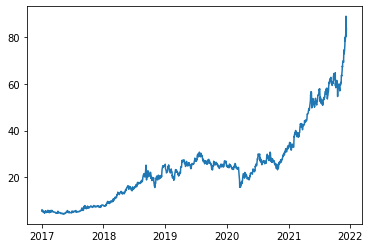

In [48]:
plt.plot(predictors['carbon_price'])
# plt.savefig(f'./EDA/joan_miro_price_ts.pdf')
plt.show()

In [49]:
# predictors = predictors.groupby('date').mean()
# predictors

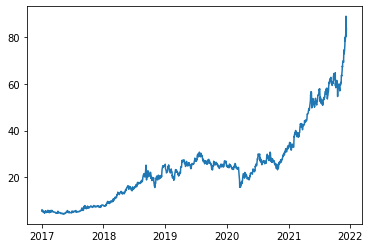

In [50]:
plt.plot(predictors['carbon_price'])
plt.show()

In [51]:
tf_idf = pd.read_csv( f'{methodology}_{data_source}_{glossary_source}_{version}keywords.csv', index_col = 0 )
tf_idf.index.name = 'date'
tf_idf.index = pd.to_datetime( tf_idf.index )

In [52]:
tf_idf = pd.read_csv( f'{methodology}_{data_source}_{glossary_source}_{version}keywords.csv',
                     index_col=0, parse_dates=True)
tf_idf.index.name = 'date'

In [53]:
tf_idf.columns

Index(['emissions', 'fossil_fuel', 'gas', 'policy', 'renewables'], dtype='object')

# Exploratory Data Analysis

## Carbon price dynamics

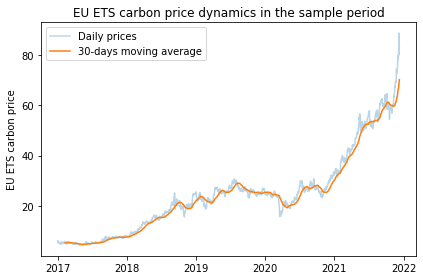

In [ ]:
plt.plot(predictors[[dep_var]], label="Daily prices", alpha=0.3)
plt.plot(predictors[[dep_var]].rolling(rolling_mean_length).mean(),
         label=f"{rolling_mean_length}-days moving average")
plt.ylabel('EU ETS carbon price')
plt.title(f'EU ETS carbon price dynamics in the sample period')
plt.legend()
plt.tight_layout()
plt.savefig(f'./EDA/{dep_var}_ts.pdf')
plt.show()

## Control variable correlation

In [ ]:
predictors.columns

Index(['carbon_price', 'oil_price', 'energy_price', 'gas_price', 'coal_price',
       'stock_price', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37'],
      dtype='object')

In [ ]:
corr_var = 'oil_price'

In [ ]:
ret_df = predictors.pct_change()

In [ ]:
corr_ts = ret_df[dep_var].rolling(rolling_corr_length).corr(ret_df[corr_var])

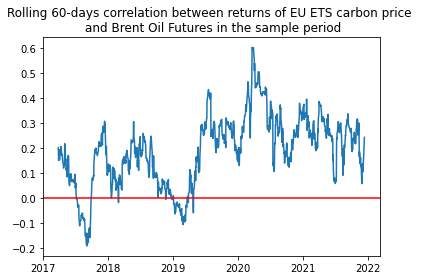

In [ ]:
plt.plot(corr_ts)
plt.title(f'Rolling {rolling_corr_length}-days correlation between returns of {var_name_map[dep_var]} \n and {var_name_map[corr_var]} in the sample period')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.savefig(f'./EDA/{dep_var}_{corr_var}_corr_ts.pdf')
plt.show()

In [ ]:
corr_vars = ['oil_price', 'energy_price', 'gas_price', 'coal_price', 'stock_price']

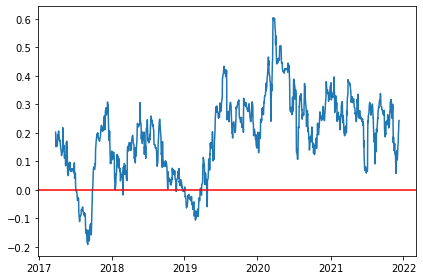

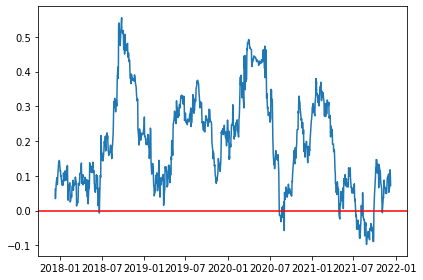

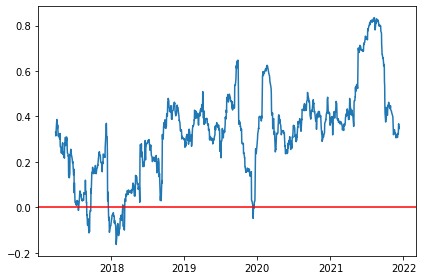

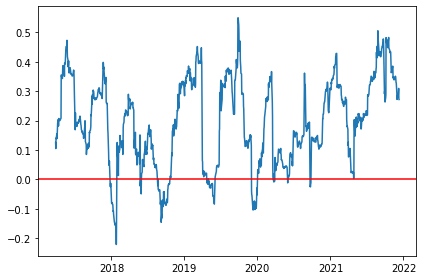

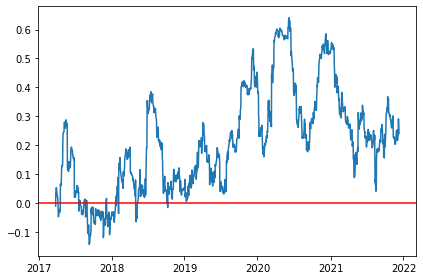

In [ ]:
for corr_var in corr_vars:
    corr_ts = ret_df[dep_var].rolling(rolling_corr_length).corr(ret_df[corr_var])
    plt.plot(corr_ts)
    # plt.title(f'Rolling {rolling_corr_length}-days correlation between returns of {var_name_map[dep_var]} \n and {var_name_map[corr_var]} in the sample period')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.tight_layout()
    plt.savefig(f'./EDA/{dep_var}_{corr_var}_corr_ts.pdf')
    plt.show()

## Keyword correlations

In [ ]:
keyword_groups = ['emissions', 'fossil_fuel', 'gas', 'policy', 'renewables']

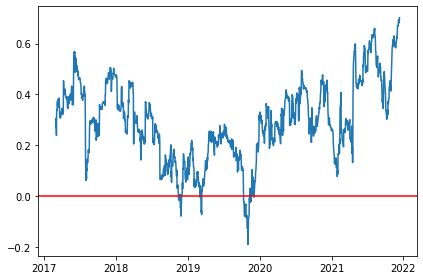

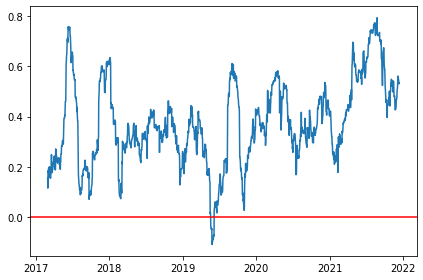

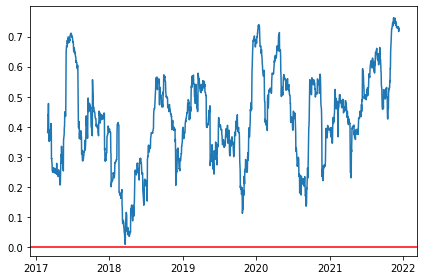

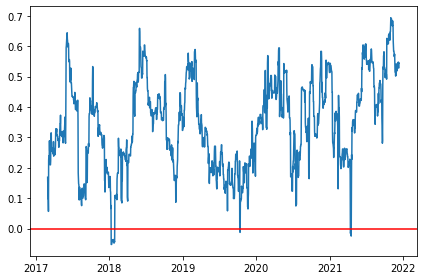

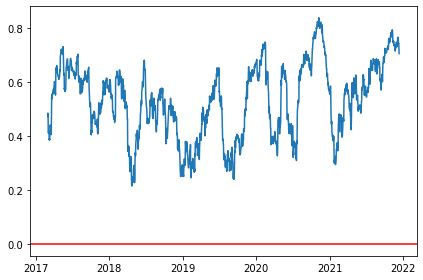

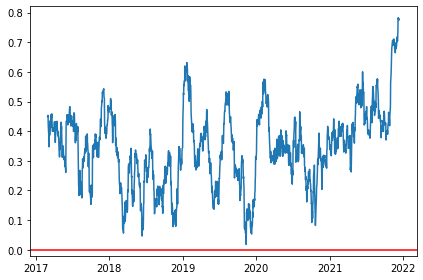

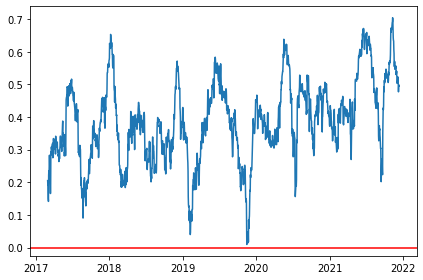

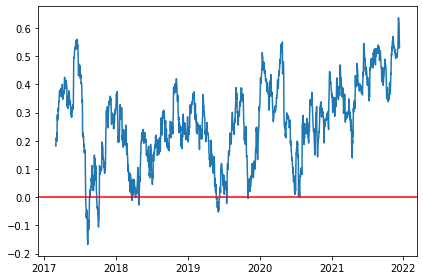

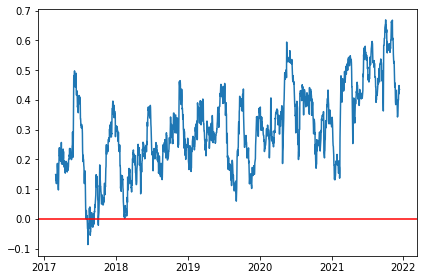

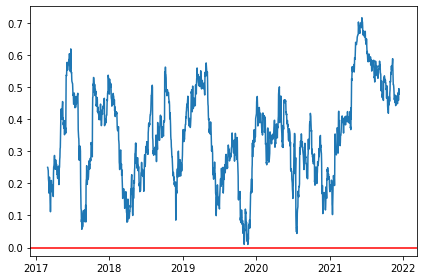

In [ ]:
traversed_combinations = []
for i, j in list(itertools.product(keyword_groups, keyword_groups)):
    if (i != j) & ((j, i) not in traversed_combinations):
        corr_ts = tf_idf[i].rolling(rolling_corr_length).corr(tf_idf[j])
        plt.plot(corr_ts)
        # plt.title(f'Rolling {rolling_corr_length}-days correlation between {methodology_name_map[methodology]} scores of {var_name_map[i]} \n and {var_name_map[j]} in the sample period')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.tight_layout()
        plt.savefig(f'./EDA/{i}_{j}_keyword_corr_ts.pdf')
        plt.show()

        traversed_combinations.append((i, j))

## Keyword correlation heatmap

In [ ]:
tf_idf.corr()

,emissions,fossil_fuel,gas,policy,renewables
emissions,1.000000,0.296142,0.380379,0.460476,0.362815
fossil_fuel,0.296142,1.000000,0.538419,0.357297,0.389264
gas,0.380379,0.538419,1.000000,0.276964,0.302010
policy,0.460476,0.357297,0.276964,1.000000,0.369786
renewables,0.362815,0.389264,0.302010,0.369786,1.000000


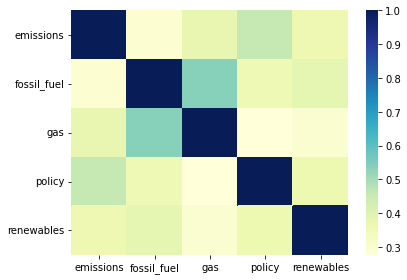

In [54]:
ax = sns.heatmap(tf_idf.corr(), cmap="YlGnBu")
plt.tight_layout()
plt.savefig(f'./EDA/{methodology}_keyword_corr_heatmap.pdf')
plt.show()